# Data620 Final Project

For my final project, I wanted to expand the spam classifer by using my own inbox to detect a spam email. This will require me to scrape my own inbox and personal mail to obtain regular emails and spam  emails to predict oncoming new emails are spam or not spam. 


In [2]:
# Import modules for python
import os
import datetime
from datetime import date
from datetime import datetime as dt
import win32com.client as win32com
from bs4 import BeautifulSoup
import re
import zipfile
import urllib
import glob
import sys
import datetime
import numpy as np
import pandas as pd
import sys 
from datetime import timedelta
import re
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Set up Email Account

For this project, I decided to use my school email address as a sample to creat a spam classifer. This was fairly complicated since it required me scraping my own inbox. For this I used the win32 package which is able to scrape packages on your windows such as outlook.

In [3]:
win32com.dynamic.Dispatch('Outlook.Application')
outlook = win32com.Dispatch("Outlook.Application")
mapi = outlook.GetNamespace('MAPI')
email = 'munkhnaran.gankhuyag84@spsmail.cuny.edu'

The find folder function helps find the folder that I wanted to look into.

In [4]:
#create a function to find folder

def findFolder(folderName,searchIn):
    print(folderName)
    print(searchIn)
    result = None
    try:
        lowerAccount = searchIn.Folders
        firstItem = lowerAccount.GetFirst()
        if firstItem.Name.lower() == folderName.lower():
            return firstItem
        else:
            while True:
                NextItem = lowerAccount.GetNext()
                if NextItem is None:
                    print("Trouble accessing subfolder")
                    break
                else:
                    print(NextItem.Name)
                    if NextItem.Name.lower() == folderName.lower():
                        result = NextItem
                        break
                    else:
                        continue
    except:
        print("Looks like we had an issue accessing the searchIn object")
    return result

In [5]:
#Access the main folder
main_folder = findFolder(email, mapi)

munkhnaran.gankhuyag84@spsmail.cuny.edu
Mapi
mikegankhuyag@outlook.com
Munkhnaran.Gankhuyag84@spsmail.cuny.edu


In [6]:
inbox = findFolder('Inbox', main_folder)

Inbox
Munkhnaran.Gankhuyag84@spsmail.cuny.edu
Inbox


In [7]:
junk = findFolder('Junk Email',main_folder)

Junk Email
Munkhnaran.Gankhuyag84@spsmail.cuny.edu
Inbox
Outbox
Sent Items
Contacts
Yammer Root
Tasks
Scheduled
PersonMetadata
Notes
Junk Email


In [8]:
messages_inbox = inbox.Items
messages_inbox.Sort('CreationTime', 1)

In [9]:
messages_inbox.GetFirst().Subject

'Daily Notification Dashboard Summary'

In [10]:
messages_spam = junk.Items
messages_spam.Sort('CreationTime', 1)

In [11]:
messages_spam.GetFirst().Subject

'Hey, is this your story?'

I wanted to get a sample of both spam and inbox for testing. I created two seperate dataframes and then decided to concatinate the two data frame together.

In [12]:
#Get spam email for sample

x = messages_spam.GetFirst().Body

spam = []

spam.append(x)

for i in range(messages_spam.Count-1):
    spam.append(messages_spam.GetNext().Body)
    

In [13]:
spam = [item.replace('\r','').replace('\n','').replace('/','') for item in spam]

In [14]:
spam = pd.DataFrame(spam, columns=['email'])

In [15]:
spam['type'] = 'spam'
spam = spam[['type','email']]

In [16]:
#Get email for sample
x = messages_inbox.GetFirst().Body

inbox = []

inbox.append(x)

for i in range(messages_inbox.Count-1):
    inbox.append(messages_inbox.GetNext().Body)

In [17]:
import random
random.shuffle(inbox)

In [18]:
inbox2 = inbox[:15]

In [19]:
inbox2 = [item.replace('\r','').replace('\n','').replace('/','') for item in inbox2]

In [20]:
inbox2 = pd.DataFrame(inbox2, columns =['email'])

In [21]:
inbox2['type']= 'inbox'
inbox2 = inbox2[['type','email']]

In [22]:
all_email = pd.concat([inbox2,spam]).reset_index(drop=True)

In [23]:
all_email.groupby('type').describe()

email                                                               
      count unique                                                top freq
type                                                                      
inbox    15     15  Hi there, Tuition for all of our Product Schoo...    1
spam     18     18  This is my last email of 2018. 2019 is just a ...    1

In [24]:
all_email['length'] = all_email['email'].map(lambda text: len(text))
all_email.head()

,type,email,length
0,inbox,"As mentioned during our last meetup, we didn't...",182
1,inbox,<http:www1.cuny.edumucontentfiles201710cuny_l...,6832
2,inbox,"Hi there, We have Product Management, Coding, ...",1551
3,inbox,"\t\t\t\tHi there,Can a machine distinguish bet...",2260
4,inbox,"Dear Student, Assuming all goes well in the cu...",3555


In [25]:
all_email.hist(column='length', by='type', bins=50)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B9ED31940>,
      dtype=object)

After getting the sample, I wanted to do some quick analysis such as sample size

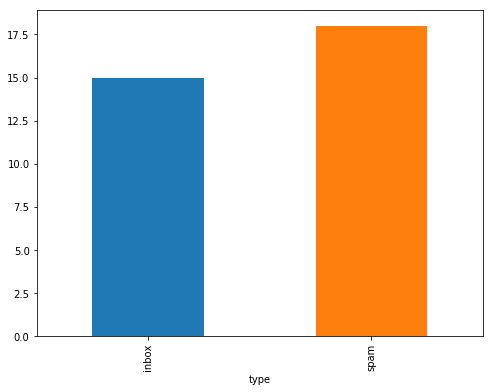

In [26]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
all_email.groupby('type').email.count().plot.bar(ylim=0)
plt.show()

I used TextBlob,stopwords and isaplha function to clean up the data.

In [27]:
from textblob import TextBlob
def split_into_tokens(message):
  # convert bytes into proper unicode
    return TextBlob(message).words

In [28]:
all_email.email.head().apply(split_into_tokens)

0    [As, mentioned, during, our, last, meetup, we,...
1    [http, www1.cuny.edumucontentfiles201710cuny_l...
2    [Hi, there, We, have, Product, Management, Cod...
3    [Hi, there, Can, a, machine, distinguish, betw...
4    [Dear, Student, Assuming, all, goes, well, in,...
Name: email, dtype: object

In [29]:
def split_into_lemmas(message):
    words = TextBlob(message).words
    words = [x for x in words if x not in stopwords.words('english')]
    words = [x for x in words if x.isalpha()]
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]


In [30]:
all_email.email.head().apply(split_into_lemmas)

0    [As, mentioned, last, meetup, session, October...
1    [http, The, Thursday, Brief, May, http, The, C...
2    [Hi, We, Product, Management, Coding, Data, An...
3    [Hi, Can, machine, distinguish, honey, bee, bu...
4    [Dear, Student, Assuming, go, well, current, s...
Name: email, dtype: object

Testing the classifier

In [32]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(all_email['email'])
len(bow_transformer.vocabulary_)

2279

In [90]:
message20 = all_email['email'][20]
print(message20)

Hello All,Our meetup will be starting momentarily. It looks like I'm locked out of our CUNY gotomeeting link, and I don't think I'd be able to coordinate the verification code in time to get started. So, for today we'll be temporarily using my company's account:https:www.gotomeet.meCharleyFerrariSorry for the confusion, and hope to see everyone shortly!


In [91]:
bow4 = bow_transformer.transform([message20])

bow4.shape

(1, 2279)

In [92]:
print(bow_transformer.get_feature_names()[72])

Art


In [93]:
messages_bow = bow_transformer.transform(all_email['email'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))


sparse matrix shape: (33, 2279)
number of non-zeros: 4044
sparsity: 5.38%


In [99]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)

In [97]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(33, 2279)


In [103]:
spam_detector = MultinomialNB().fit(messages_tfidf, all_email['type'])

In [101]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(33, 2279)


Predict email using the sample email abov

In [105]:
print('predicted: ' , spam_detector.predict(tfidf4)[0])
print('expected: ', all_email.type[20])

predicted:  spam
expected:  spam


Predict all emails

In [106]:
all_predictions = spam_detector.predict(messages_tfidf)
print(all_predictions)

['inbox' 'inbox' 'inbox' 'inbox' 'inbox' 'inbox' 'inbox' 'inbox' 'inbox'
 'inbox' 'inbox' 'inbox' 'inbox' 'inbox' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam']


Since we didn't re order out emails, it gives the correct predictions as to which ones are spam and which ones are not.

In [107]:
print('accuracy', accuracy_score(all_email['type'], all_predictions))
print('confusion matrix\n', confusion_matrix(all_email['type'], all_predictions))
print('(row=expected, col=predicted)')

accuracy 0.9696969696969697
confusion matrix
 [[14  1]
 [ 0 18]]
(row=expected, col=predicted)


Text(0.5,0,'predicted label')

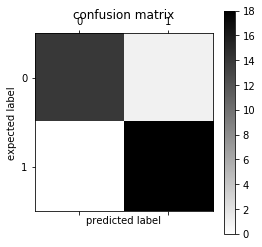

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(confusion_matrix(all_email['type'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [109]:
print(classification_report(all_email['type'], all_predictions))

             precision    recall  f1-score   support

      inbox       1.00      0.93      0.97        15
       spam       0.95      1.00      0.97        18

avg / total       0.97      0.97      0.97        33



Word Cloud Visuals -- Inbox wrods

In [122]:
all_email2 = pd.DataFrame(all_email).reset_index(drop=True)
all_email2['email'] = all_email2['email'].str.lower().str.split()
all_email2['email'] = all_email2['email'].apply(lambda x: [item for item in x if item.isalpha()])
#stopwords
all_email2['email'] = all_email2['email'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])

for i in range(len(all_email2[all_email2['type']=='inbox']['email'])):
    inbox_words = ' '.join(list(all_email2[all_email2['type']=='inbox']['email'][i]))    

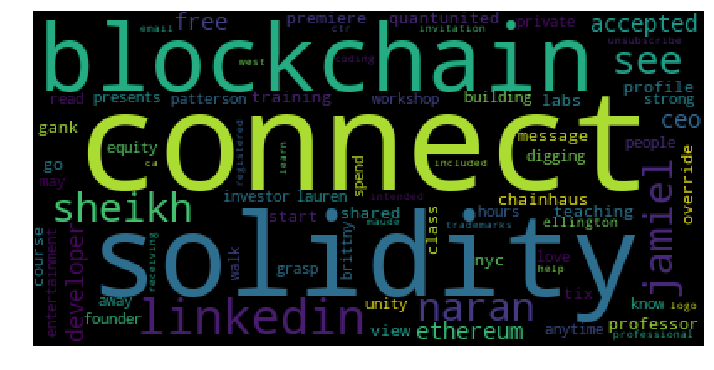

In [123]:

inbox_word_cloud = WordCloud().generate(inbox_words)
plt.figure(figsize = (10,10), facecolor = 'w')
plt.imshow(inbox_word_cloud)
plt.axis('off')
plt.tight_layout(pad = 1)
plt.show()

Next steps is to improve the application by adding different types of spam. Since I used my school email, the spams in my spam folders were still relavent to cuny and the data science program. After further improvements, it can be used to build a social network for who is sending spam and who is not. This similar project can be used to specify not just spam or not spam emails, but classifying differnt subjects or requests.